# User Agents in SavePageNow

This notebook examines the User Agents that were used when asking for content to be saved at Internet Archive's SavePageNow.

The User-Agent string has been used since the early days of the web as a way of identifying the software that is being used to access a web page. It is currently defined by [RFC 7231](https://tools.ietf.org/html/rfc7231#section-5.5.3) as a set of one ore more *product identifiers* which identify the software being used to perform the HTTP request.

    User-Agent      = product *( RWS ( product / comment ) )
    product         = token ["/" product-version]
    product-version = token
    
So for example the browser I am using now has this User-Agent:

    Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0
    
The product identifiers here are typically listed in increasing levels of specificity. 

* Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0)
* Gecko/20100101
* Firefox/66.0

But they are freeform enough that the [ua-parser](https://www.uaparser.org/) project has built up a voluminous set of regular expressions to parse and make sense of them.

The question is, what can the User-Agent's in the SavePageNow data tell us about the people who are participating in creation of the Internet Archive.

## Analyze

To find the User-Agents that were used to archive the web content we need to excavate the SavePageNow WARC data. WARC files store verious [types of records](https://iipc.github.io/warc-specifications/specifications/warc-format/warc-1.1/#warc-type-mandatory). In this case we need to find the *Request* records that represent the HTTP request that was used by SavePageNow to archive the content from the Web. Using Spark with warcio is one way of doing this analysis:

In [1]:
import sys
sys.path.append('../utils')

from warc_spark import init, extractor
sc, sqlc = init()

An extractor function to get the User-Agent from the *WARC Request* objects:

In [3]:
@extractor
def ua(rec):
    if rec.rec_type == 'request':
        yield rec.http_headers.get('user-agent', '')

Now let's create a function that will run a Spark job to get the User-Agent counts for a year as a dictionary.

In [8]:
from glob import glob

def get_year(year):
    warc_files = glob('warcs/liveweb-{}*/*.warc.gz'.format(year))
    warcs = sc.parallelize(warc_files)
    output = warcs.mapPartitions(ua)
    return output.countByValue()

Now we can use `get_year` for each year of data we have for SPN and create a pandas DataFrame of the results.

In [ ]:
import pandas

ua_data = {}
for year in range(2013, 2019):
    print(year)
    ua_data[str(year)] = get_year(year)

df = pandas.DataFrame(ua_data)
df.index.name = 'ua'

2013
2014
2015
2016
2017
2018


We can quickly examine it to make sure it looks like it worrked:

In [ ]:
df.head()

Let's definitely save it for later, since it took about 6 hours to compute on XSEDE!

In [ ]:
df.to_csv('results/user-agents.csv')

## Top 10 User Agents

Let's see if we can find any rhyme or reason in this data. If the CSV has already been calculated we can load it here instead of waiting 6 hours for the analysis to run.

In [1]:
import pandas

df = pandas.read_csv('results/user-agents.csv', index_col='ua')

What are the top 10 per year? We can iterate through the years and generate a table from our DataFrame for each year:

In [2]:
from IPython.display import display, Markdown

# create chunks of Markdown tables to display

for year in range(2013, 2019):
    y = str(year)
    md_lines = [
    "### {}".format(y),
    "| user-agent | count |",
    "| ---------- | ----- |"
]
    dfy = df.sort_values(by=y, ascending=False)
    for ua, count in dfy[y].head(10).items():
        if count > 0:
            md_lines.append("| {} | {} |".format(ua, count))
    display(Markdown("\n".join(md_lines)))

### 2013
| user-agent | count |
| ---------- | ----- |
| Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot) | 1238598.0 |
| nan | 27477.0 |

### 2014
| user-agent | count |
| ---------- | ----- |
| Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.104 Safari/537.36 (via Wayback Save Page) | 135766.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0 (via Wayback Save Page) | 81716.0 |
| Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.104 Safari/537.36 (via Wayback Save Page) | 76425.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko (via Wayback Save Page) | 61961.0 |
| Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot) | 56591.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; rv:33.0) Gecko/20100101 Firefox/33.0 (via Wayback Save Page) | 49612.0 |
| Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.104 Safari/537.36 (via Wayback Save Page) | 48449.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; rv:17.0) Gecko/20100101 Firefox/17.0 (via Wayback Save Page) | 30932.0 |
| Mozilla/5.0 (Windows NT 6.3; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0 (via Wayback Save Page) | 27085.0 |
| Mozilla/5.0 (Windows NT 6.1; rv:32.0) Gecko/20100101 Firefox/32.0 (via Wayback Save Page) | 26100.0 |

### 2015
| user-agent | count |
| ---------- | ----- |
| Mozilla/5.0 (Windows NT 6.1; WOW64; rv:41.0) Gecko/20100101 Firefox/41.0 (via Wayback Save Page) | 109033.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.71 Safari/537.36 (via Wayback Save Page) | 89467.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36 (via Wayback Save Page) | 75917.0 |
| Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/30.0.1599.17 Safari/537.36 (via Wayback Save Page) | 59968.0 |
| Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36 (via Wayback Save Page) | 50673.0 |
| Mozilla/5.0+(compatible; UptimeRobot/2.0; http://www.uptimerobot.com/) (via Wayback Save Page) | 50361.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko (via Wayback Save Page) | 50297.0 |
| Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36 (via Wayback Save Page) | 44944.0 |
| Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.71 Safari/537.36 (via Wayback Save Page) | 43370.0 |
| Mozilla/5.0 (Windows NT 10.0; WOW64; rv:41.0) Gecko/20100101 Firefox/41.0 (via Wayback Save Page) | 42281.0 |

### 2016
| user-agent | count |
| ---------- | ----- |
| Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot) | 1211109.0 |
| nan | 886441.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36 | 130914.0 |
| Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36 | 121033.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; rv:49.0) Gecko/20100101 Firefox/49.0 | 114269.0 |
| Mozilla/5.0 (Windows NT 6.3; WOW64; rv:49.0) Gecko/20100101 Firefox/49.0 | 105372.0 |
| Mozilla/5.0 (Windows NT 10.0; WOW64; rv:49.0) Gecko/20100101 Firefox/49.0 | 100382.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36 | 92051.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36 | 74867.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko | 71952.0 |

### 2017
| user-agent | count |
| ---------- | ----- |
| Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot) | 6633531.0 |
| okhttp/3.8.1 | 4096817.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36 | 266695.0 |
| curl/7.52.1 | 206883.0 |
| Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36 | 120292.0 |
| Mozilla | 100322.0 |
| Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/30.0.1599.17 Safari/537.36 | 99970.0 |
| Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36 | 77720.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:56.0) Gecko/20100101 Firefox/56.0 | 70324.0 |
| python-requests/2.13.0 | 65643.0 |

### 2018
| user-agent | count |
| ---------- | ----- |
| Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot) | 1487305.0 |
| Wget/1.19.5 (linux-gnu) | 719941.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36 | 560050.0 |
| Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; http://archive.org/details/archive.org_bot) | 506645.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:62.0) Gecko/20100101 Firefox/62.0 | 243023.0 |
| Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36 | 223078.0 |
| Wget/1.19.4 (darwin17.3.0) | 154725.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.67 Safari/537.36 | 109281.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36 | 103726.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534+ (KHTML, like Gecko) BingPreview/1.0b | 75130.0 |

## Shifting Infrastructure

A few interesting things pop out from just looking at the top 10 User-Agents by year. The first is that SavePageNow itself as a piece of software infrastructure has changed over the years. In 2013 it archived content from the web as

    Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record;
    
So as SavePageNow received requests from users to archive web content it simply went and requested those items from the web using a fixed User-Agent string. There is only one type of User-Agent that appears in all the HTTP requests in the WARC data for 2013 (or at least the day we sampled for that year).

But in 2014 the User-Agent strings are much more varied. For example the top User-Agent was:

    Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.104 Safari/537.36 (via Wayback Save Page)`.

This User-Agent string identifies a particular vesion of Chrome running on Windows. But also notice that appended on the end of this and other User-Agents in the list is the string `(via Wayback Save Page)`. It looks like in 2014 SavePageNow started using the User-Agent of the browser that original requestor, added an identifier for SavePageNow to the end, and then used that when requesting the web resource to archive.

So in theory, web servers that log User-Agents would see User-Agents of that form in their server logs when SavePageNow was archiving content on their site.

But then in 2016 things shift again and the top User-Agent changes to:

    Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot)
    
This User-Agent uniquely identifies *Wayback Machine Live Record* as a generic web client. While this is the #1 user agent for 2016, 2017, and 2018 it is always followed by a long tail of User-Agent strings that uniquely identifies a type of web client software, but the `(via Wayback Save Page)` has been dropped from the end. For example:

    Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36 	

What might be going on here? 	

One explanation is that in 2016 the SavePageNow software was adjusted so that when it archived web content it no longer appended `(via Wayback Save Page)` to the original User-Agent that requested the archive. It simply passed that original User-Agent through to its final destination.

However the large number of `Wayback Machine Live Record` User-Agents is a bit of a mystery. When a browser requests something be archived could it be that request is passed through with the original User-Agent, but when it receives the HTML for that web page, and buids the DOM for it, resolving URLs for images, CSS, and JavaScript those subsequent requests get the `Wayback Machine Live Record` User-Agent when passing through SavePageNow? Or perhaps `Wayback Machine Live Record` is only used when no User-Agent is supplied initially? User-Agent is optional, and there appear to be no WARC records that lack it.

It's difficult to say without taking a much closer look at the WARC data. Which we will be doing in another notebook. It is interesting how in trying to use SavePageNow WARC data to understand the users of SavePageNow we've fallen down the rabbit hole of trying to understand the SavePageNow as a technical artifact.


## The Long-ish Tail

Looking at the top 10 User-Agent was a useful start. But it also could be obscuring some patterns. So how many distinct User-Agent strings were there?


In [12]:
len(df.index)

93843

93,843 is a lot of User-Agent strings! It might be interesting to examine what proportion of all the requests for a given year were from user agents in the top 10 for that year. To do that we need to massage our dataframe into a new dataframe so that we can easily visualize it with [Altair](https://altair-viz.github.io/).

In [4]:
ratios = {'bucket': [], 'year': [], 'requests': []}

for year in range(2013, 2019):
    y = str(year)
    dfy = df.sort_values(by=y, ascending=False)
    
    ratios['year'].append(y)
    ratios['bucket'].append('top-10')
    ratios['requests'].append(dfy[y].head(10).sum())
    
    ratios['year'].append(y)
    ratios['bucket'].append('the-rest')
    ratios['requests'].append(dfy[y][10:].sum())

ratios = pandas.DataFrame(ratios)
ratios.head()

,bucket,requests,year
0,top-10,1266075.0,2013
1,the-rest,0.0,2013
2,top-10,594637.0,2014
3,the-rest,966720.0,2014
4,top-10,616311.0,2015


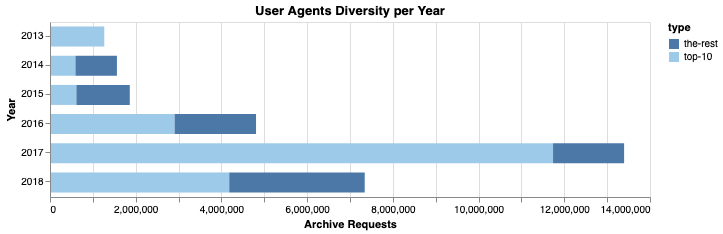

In [7]:
import altair
altair.renderers.enable('notebook')

chart1 = altair.Chart(ratios).mark_bar(size=20).encode(
    altair.X('sum(requests)', title='Archive Requests'),
    altair.Y('year', title='Year'),    
    altair.Color('bucket', title='type', scale=altair.Scale(scheme='tableau20'))
)
chart1 = chart1.properties(
    width=600,
    height=175,
    title='User Agents Diversity per Year'
)
chart1

This is a helpful visualization because it shows that most of the time (except for year 1 when there is only one type of User-Agent) the top-10 User-Agents account for about 1/2 of the total requests. So there is definitely some diversity that's worth accounting for.

But 2017 is unusual in that by far the top-10 User-Agents account for the majority of the requests. Also there appears to have been almost double the amount of WARC request records that year, as compared to the year following. This is counter-intuitive because the amount of WARC data on disk does not follow that same trend. 

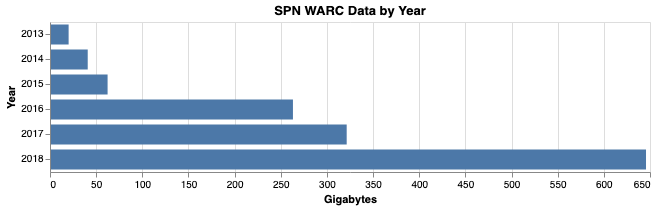

In [9]:
from os.path import getsize

sizes = {'year': [], 'gb': []}
for year in range(2013, 2019):
    sizes['year'].append(str(year))
    warc_files = glob('warcs/liveweb-{}*/*.warc.gz'.format(year))
    sizes['gb'].append(sum([getsize(path) for path in warc_files]) / (1024 ** 3))
sizes = pandas.DataFrame(sizes)
    
chart2 = altair.Chart(sizes).mark_bar(size=20).encode(
    altair.X('gb', title='Gigabytes'),
    altair.Y('year', title='Year')
)
chart2 = chart2.properties(title='SPN WARC Data by Year', width=600, height=150)
chart2

## User-Agent Families

As mentioned above there is some method in the madness of these strings. Fortunately the [ua-parser](https://www.uaparser.org/) project has built a dataset uf UserAgents, and used it to create a parser toolkit for various languages. There is one for Python that we can use to try to lump some of this data together by type of browser.

For example we can give ua_parser this string, and get back a dictionary with keys for device, os, and user_agent.

    Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Safari/605.1.15


In [12]:
import sys
print(sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


In [13]:
import json
from ua_parser.user_agent_parser import Parse as parse_ua

ua = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Safari/605.1.15'
print(json.dumps(parse_ua(ua), indent=2))

{
  "user_agent": {
    "family": "Safari",
    "major": "12",
    "minor": "0",
    "patch": null
  },
  "os": {
    "family": "Mac OS X",
    "major": "10",
    "minor": "13",
    "patch": "6",
    "patch_minor": null
  },
  "device": {
    "family": "Other",
    "brand": null,
    "model": null
  },
  "string": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Safari/605.1.15"
}


Even if the UserAgent is a string from a client like curl or wget ua-parser still does something useful:

In [14]:
ua = 'curl/7.55.1'
print(json.dumps(parse_ua(ua), indent=2))

{
  "user_agent": {
    "family": "curl",
    "major": "7",
    "minor": "55",
    "patch": "1"
  },
  "os": {
    "family": "Other",
    "major": null,
    "minor": null,
    "patch": null,
    "patch_minor": null
  },
  "device": {
    "family": "Other",
    "brand": null,
    "model": null
  },
  "string": "curl/7.55.1"
}


So it looks like we can use the *user_agent.family* to group the User-Agent strings into a single value that identifies the piece of software (e.g. Safari, Firefox, curl, etc). Let's use our existing data to create a new DataFrame where the index is the *family_name* and the columns are the request counts by year. Along the way we'll also populate `ua_fam_map` which is a dictionary lookup for User-Agents to easily get their family. It turns out ua-parser is kinda slow and it will be useful to be able to do this operation quickly.

*Note: if ua-parser is unable to assign a family we will keep the original user-agent string (lines 9-10).*

In [16]:
from collections import defaultdict

ua_fams = defaultdict(defaultdict)
ua_fam_map = {}
for ua in df.index:
    
    if type(ua) != str:
        continue
        
    parsed_ua = parse_ua(ua)
    ua_fam = parsed_ua['user_agent']['family']
    if ua_fam == 'Other':
        ua_fam = ua
        
    ua_fam_map[ua] = ua_fam
        
    for year in range(2013, 2019):
        y = str(year)
        if df.loc[ua][y] > 0:
            if y in ua_fams[ua_fam]:
                ua_fams[ua_fam][y] += df.loc[ua][y]
            else:
                ua_fams[ua_fam][y] = df.loc[ua][y]

ua_fams = pandas.DataFrame.from_dict(ua_fams, orient='index')
ua_fams.to_csv('results/user-agent-families.csv')

What do the top-10 User-Agent families look like?

In [17]:
ua_fams = ua_fams.sort_values(by='2018', ascending=False)
print(ua_fams.head(10))

                            2016       2017       2018      2015      2014  \
archive.org_bot        1211109.0  6633606.0  1993950.0   21919.0   56592.0   
Chrome                 1148250.0   974904.0  1847441.0  733229.0  528107.0   
Wget                     21169.0   112692.0   884542.0   41166.0     412.0   
Firefox                 663526.0   450984.0   815868.0  446959.0  477219.0   
Chrome Mobile            46737.0    55821.0   378808.0   37569.0   23113.0   
Mobile Safari            62882.0    54805.0   242143.0   61445.0   51708.0   
Safari                   98126.0    59622.0   141215.0   77051.0   61123.0   
IE                      223213.0   115447.0   113192.0  173350.0  223003.0   
BingPreview                125.0     2595.0   103098.0      28.0      41.0   
Chrome Mobile WebView     3807.0     6865.0    99748.0    5290.0       NaN   

                            2013  
archive.org_bot        1238598.0  
Chrome                       NaN  
Wget                         NaN  
F

How many User-Agent families are there?


In [18]:
print(len(ua_fams.index))

919


So there are now several orders of magnitude *less* User-Agents (remember the full list was 93,843. Let's run our top-10 stats again and see how it looks:

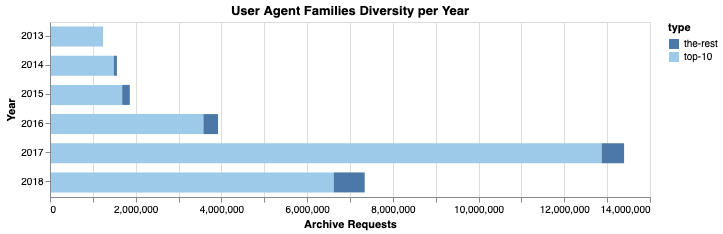

In [19]:
ratios2 = {'bucket': [], 'year': [], 'requests': []}

for year in range(2013, 2019):
    y = str(year)
    dfy = ua_fams.sort_values(by=y, ascending=False)
    
    ratios2['year'].append(y)
    ratios2['bucket'].append('top-10')
    ratios2['requests'].append(dfy[y].head(10).sum())
    
    ratios2['year'].append(y)
    ratios2['bucket'].append('the-rest')
    ratios2['requests'].append(dfy[y][10:].sum())

ratios2 = pandas.DataFrame(ratios2)

chart3 = altair.Chart(ratios2).mark_bar(size=20).encode(
    altair.X('sum(requests)', title='Archive Requests'),
    altair.Y('year', title='Year'),    
    altair.Color('bucket', title='type', scale=altair.Scale(scheme='tableau20'))
)
chart3 = chart3.properties(
    width=600,
    height=175,
    title='User Agent Families Diversity per Year'
)
chart3

Nice, so our long tail of User-Agents may be long, but it doesn't account for many requests relative to the total volume. So what is the full set of top-10 User-Agents?

In [20]:
top_10_uas = set()
for year in range(2013, 2019):
    y = str(year)
    for ua in ua_fams.sort_values(by=y, ascending=False).head(10).index:
        top_10_uas.add(ua)

top_10_uas

{'Android',
 'BingPreview',
 'Chrome',
 'Chrome Mobile',
 'Chrome Mobile WebView',
 'Firefox',
 'Firefox Mobile',
 'IE',
 'Mobile Safari',
 'Mozilla',
 'OpenBSD ftp',
 'Opera',
 'Python Requests',
 'Safari',
 'UptimeRobot',
 'Wget',
 'archive.org_bot',
 'curl',
 'okhttp'}

How about the top-50 per year?

In [21]:
top_50_uas = set()
for year in range(2013, 2019):
    y = str(year)
    for ua in ua_fams.sort_values(by=y, ascending=False).head(50).index:
        top_50_uas.add(ua)

top_50_uas

{'AhrefsBot',
 'Amazon Silk',
 'Android',
 'Apache-HttpClient',
 'AppEngine-Google',
 'Apple Mail',
 'BingPreview',
 'BlackBerry WebKit',
 'CheckHost (http://check-host.net/)',
 'Chrome',
 'Chrome 41.0.2227.0',
 'Chrome 41.0.2227.1',
 'Chrome 41.0.2228.0',
 'Chrome Mobile',
 'Chrome Mobile WebView',
 'Chrome Mobile iOS',
 'Chromium',
 'Coc Coc',
 'Dragon',
 'Edge',
 'Edge Mobile',
 'FUCKING CLOUDFLARE!',
 'Facebook',
 'FacebookBot',
 'Firefox',
 'Firefox (Namoroka)',
 'Firefox (via Wayback Save Page)',
 'Firefox 33.0',
 'Firefox 36.0',
 'Firefox 40.1',
 'Firefox Mobile',
 'Firefox iOS',
 'HTTPClient/1.0 (2.3.4.1, ruby 1.9.3 (2014-05-14)) (via Wayback Save Page)',
 'Hatena Antenna/0.5 (http://a.hatena.ne.jp/help)',
 'Hatena Antenna/0.5 (http://a.hatena.ne.jp/help) (via Wayback Save Page)',
 'HeadlessChrome',
 'IE',
 'IE Mobile',
 'Iceweasel',
 'Iron',
 'Java',
 'K-Meleon',
 'LinkArchiver twitter bot',
 'Maxthon',
 'Mediapartners-Google',
 'Mobile Safari',
 'Mobile Safari UI/WKWebView',


This is a remarkable list in a way, because we see browsers such as Netscape, Puffin, K-Meleon, Iceweasel, Coc Coc, Vivaldi. Not everyone is running Chrome and Firefox apparently, at least when they use SavePageNow.

One thing we can do to simplify even more is group the User-Agent families at face value based on whether they appear to be a browser or they appear to be a bot. Let's create a list of the obvious bots, this should cover a large number of the archiving activity at least on the days we're looking at.

In [29]:
bots = [   
 'AhrefsBot',
 'Apache-HttpClient',
 'AppEngine-Google',
 'CheckHost (http://check-host.net/)',
 'Coc Coc',
 'FUCKING CLOUDFLARE!',
 'Facebook',
 'FacebookBot',
 'HTTPClient/1.0 (2.3.4.1, ruby 1.9.3 (2014-05-14)) (via Wayback Save Page)',
 'Hatena Antenna/0.5 (http://a.hatena.ne.jp/help)',
 'Hatena Antenna/0.5 (http://a.hatena.ne.jp/help) (via Wayback Save Page)',
 'HeadlessChrome',
 'Java',
 'LinkArchiver twitter bot',
 'Mediapartners-Google',
 'Mobile Safari',
 'Mobile Safari UI/WKWebView',
 'OpenBSD ftp',
 'PHP/5.4',
 'Patterbot',
 'PhantomJS',
 'Pinterest',
 'Python Requests',
 'Python Wayback Backup API-Client',
 'Python-urllib',
 'Ruby',
 'Ruby (via Wayback Save Page)',
 'Scrapy',
 'SeaMonkey',
 'Source Rescuing Bot',
 'TweetSave/0.1 (+http://tweetsave.com/)',
 'URL Status Checker/0.1 (via Wayback Save Page)',
 'UptimeRobot',
 'Watchbot',
 'WebKit2HTML/1.0',
 'Wget',
 'WordPress',
 'archive.org_bot',
 'archiver',
 'curl',
 'diffengine/0.0.42 (+https://github.com/docnow/diffengine)',
 'diffengine/0.1.0 (+https://github.com/docnow/diffengine)',
 'haskell-HTTP/4000.2.17 (via Wayback Save Page)',
 'http://Anonymouse.org/ (Unix)',
 'libwww-perl',
 'mediawords bot',
 'okhttp',
 'sentry/8.18.0 (https://sentry.io)',
 'waybackmachinedownloader'    
]

bot_ratios = {"ua": [], "bucket": [], "year": [], "requests": []}

for ua in top_50_uas:
    if ua in bots:
        bucket = "bot"
    else:
        bucket = "human"
    for year in range(2013, 2019):
        y = str(year)
        bot_ratios['ua'].append(ua)
        bot_ratios['bucket'].append(bucket)
        bot_ratios['year'].append(y)
        bot_ratios['requests'].append(ua_fams.loc[ua][y])

bot_ratios = pandas.DataFrame(bot_ratios)
bot_ratios

,bucket,requests,ua,year
0,human,NaN,Pale Moon,2013
1,human,2559.0,Pale Moon,2014
2,human,5118.0,Pale Moon,2015
3,human,5217.0,Pale Moon,2016
4,human,4676.0,Pale Moon,2017
5,human,4308.0,Pale Moon,2018
6,human,NaN,Safari 7.0.3,2013
7,human,NaN,Safari 7.0.3,2014
8,human,NaN,Safari 7.0.3,2015
9,human,NaN,Safari 7.0.3,2016


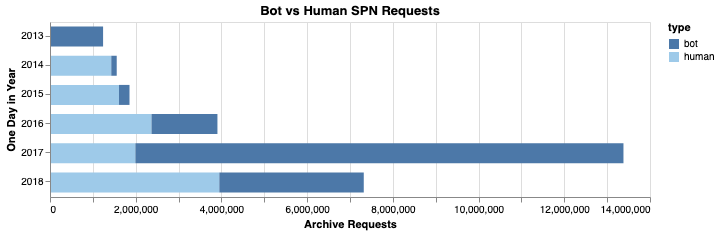

In [36]:
chart4 = altair.Chart(bot_ratios).mark_bar(size=20).encode(
    altair.X('sum(requests)', title='Archive Requests'),
    altair.Y('year', title='One Day in Year'),    
    altair.Color('bucket', title='type', scale=altair.Scale(scheme='tableau20'))
)
chart4 = chart4.properties(
    width=600,
    height=175,
    title='Bot vs Human SPN Requests'
)
chart4

So if you remember the anomalous number of requests in 2017 we can see that bots appear to have been responsible. The proportion of bot User-Agents is much greater in 2017. In fact all we have to do is look at the top User-Agent for that year, and it tells us which one is responsible:

In [31]:
dfy = df.sort_values('2017', ascending=False)
first = dfy['2017'][0]
print(dfy.index[0], dfy['2017'][0])

Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot) 6633531.0


Yes. it's the mysterious `Wayback Machine Live Record`. At 6 million requests it amounts for the majority of the bots in 2017--about half of the additional traffic. But what were these bots doing? I asked in the Internet Archive Slack and was told that this User-Agent is used by SavePageNow to request content when no User-Agent is used at all. So we can safely assume that this automated traffic since all browsers will send a User-Agent of some kind.

But what can we infer about what types of material was being archived by the bots vs the humans? Answering these questions is a topic for another notebook. But for now let's save a mapping of User-Agents to their family so we can use it later when processing WARC data.

In [37]:
json.dump(ua_fam_map, open('results/user-agent-families.json', 'w'), indent=2)

And we might as well save our top-50 User-Agents per year, along with whether we classed it as a bot or not.

In [38]:
top_uas = {ua: ua in bots for ua in top_50_uas}
json.dump(top_uas, open('results/top-user-agents.json', 'w'), indent=2)